# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import numpy as np

data_base_path = os.path.join(os.pardir, '..\data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

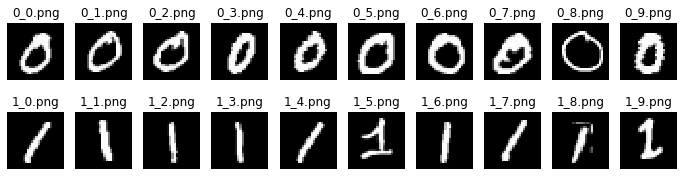

In [2]:
import skimage.io
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, '..\data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors

In [3]:
def make_binary(im, l, u):
    'Returns array where values within thresholds are 1'
    '0 elsewhere'
    
    tp = im.copy()
    
    tp[tp < l] = 0
    tp[tp > u] = 0
    tp[tp != 0] = 1
    
    return tp

In [18]:
def create_init_snake(x, y, r, resolution=400):
    'Return array of circular init coordinates'
    
    s = np.linspace(0, 2*np.pi, resolution)
    x = x + r*np.cos(s)
    y = y + r*np.sin(s)
    init = np.array([x, y]).T
    
    return init

#### Validate snake init

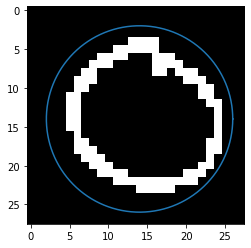

In [229]:
z = zeros_im[8]
z = make_binary(z, 122, 255)
z[z==1] = 255

mid_x, mid_y = np.array(z.shape)*0.5

'Resolution increases computational time and precision'
init = create_init_snake(mid_x, mid_y, r=12, resolution=1000)

plt.imshow(z, cmap='gray')
plt.plot(init[:,0], init[:,1])

plt.show()

#### Tune grid and snake

In [230]:
from cv2 import GaussianBlur
from skimage.segmentation import active_contour

In [231]:
im = ones_im[9]
im = make_binary(im, 122, 255)
im[im == 1] = 255

beta = 100
alpha = 0.1

'Beta will smoothen the curve, alpha will try to attach to edges (internal vs external energy)'
snake = active_contour(GaussianBlur(im, (3,3), 1), init, alpha=alpha, beta=beta, gamma=0.15, w_line=-0.1, coordinates='rc') 

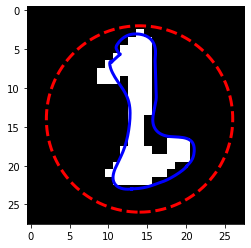

In [232]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(im, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
plt.show()

In [223]:
import cmath
def fetch_fourier_descriptors(curve, n_descriptors, scale=True, ignore_zero=True):
    
    complex_coords = [complex(xi, yi) for xi, yi in curve]
    f_trans = np.fft.fft(complex_coords)
    
    if ignore_zero: f_trans = f_trans[1:]
    
    f_trans = f_trans[:n_descriptors]
    
    amps = abs(f_trans)
    
    if scale: 
        f_trans[1:] /= amps[0]
        amps[1:] /= amps[0]
        
    return amps, f_trans

In [339]:
zeros_bin = [make_binary(z, 200, 255) for z in zeros_im]
ones_bin = [make_binary(o, 200, 255) for o in ones_im]

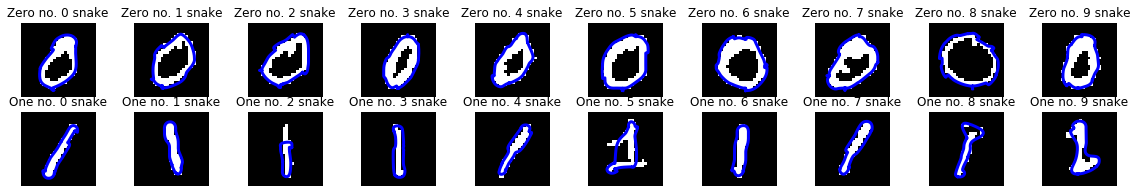

In [291]:
fig, ax = plt.subplots(2, len(zeros_im), figsize=(20,3))

zeros_amps = []
zeros_comp = []

for i, z in enumerate(zeros_bin):
    
    im = z.copy()
    im[im == 1] = 255
    
    snake = active_contour(GaussianBlur(im, (3,3), 1), init, alpha=alpha, beta=beta, gamma=0.15, w_line=-0.1, coordinates='rc')    
    amps, comp = fetch_fourier_descriptors(snake, 2, scale=True, ignore_zero=True) 
    
    zeros_amps.append(amps)
    zeros_comp.append(comp)
    
    ax[0, i].imshow(im, cmap=plt.cm.gray)
    ax[0, i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax[0, i].axis('off')
    ax[0, i].set_title(f'Zero no. {i} snake')


ones_amps = []
ones_comp = []

for i, one in enumerate(ones_bin):

    im = one.copy()
    im[im == 1] = 255
    
    snake = active_contour(GaussianBlur(im, (3,3), 1), init, alpha=alpha, beta=beta, gamma=0.15, w_line=-0.1, coordinates='rc')   
    amps, comp = fetch_fourier_descriptors(snake, 2, scale=True, ignore_zero=True)
    
    ones_amps.append(amps)
    ones_comp.append(comp)
    
    ax[1, i].imshow(im, cmap=plt.cm.gray)
    ax[1, i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax[1, i].axis('off')
    ax[1, i].set_title(f'One no. {i} snake')

In [233]:
def scatter_ax(ax, x_s, y_s, xy_names, ann_shorthands, ann_on=True):
    
    n_classes = len(x_s)
    shorthands = [[ann+str(j) for j in range(len(x_s[i]))] for i, ann in enumerate(ann_shorthands)]
    
    for i in range(n_classes):
        ax.scatter(x_s[i], y_s[i])

    if ann_on:
        for i, s in enumerate(shorthands):
            for j, sj in enumerate(s): ax.annotate(sj, (x_s[i][j], y_s[i][j]))
                                               
    ax.set_xlabel(xy_names[0])
    ax.set_ylabel(xy_names[1])
    
    return ax

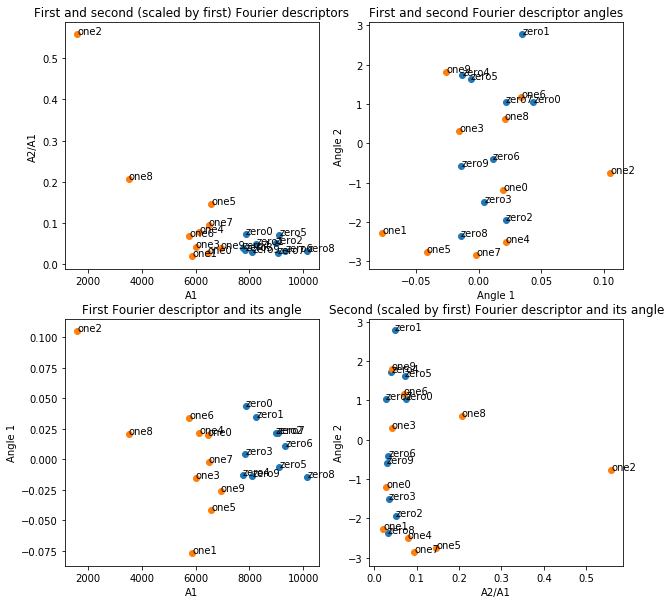

In [270]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

zeros_a1, zeros_a2 = np.array(zeros_amps)[:,0], np.array(zeros_amps)[:,1]
ones_a1, ones_a2 = np.array(ones_amps)[:,0], np.array(ones_amps)[:,1]

zeros_1_angle, zeros_2_angle = np.angle(zeros_comp)[:,0], np.angle(zeros_comp)[:,1]
ones_1_angle, ones_2_angle = np.angle(ones_comp)[:,0], np.angle(ones_comp)[:,1]

ax[0,0] = scatter_ax(ax[0,0], (zeros_a1, ones_a1), (zeros_a2, ones_a2), ('A1', 'A2/A1'), ('zero','one'))
ax[0,0].set_title('First and second (scaled by first) Fourier descriptors')

ax[0,1] = scatter_ax(ax[0,1], (zeros_1_angle, ones_1_angle), (zeros_2_angle, ones_2_angle), ('Angle 1', 'Angle 2'), ('zero', 'one'))
ax[0,1].set_title('First and second Fourier descriptor angles')

ax[1,0] = scatter_ax(ax[1,0], (zeros_a1, ones_a1), (zeros_1_angle, ones_1_angle), ('A1', 'Angle 1'), ('zero','one'))
ax[1,0].set_title('First Fourier descriptor and its angle')

ax[1,1] = scatter_ax(ax[1,1], (zeros_a2, ones_a2), (zeros_2_angle, ones_2_angle), ('A2/A1', 'Angle 2'), ('zero','one'))
ax[1,1].set_title('Second (scaled by first) Fourier descriptor and its angle')

plt.show()

**Thoughts**:
 * The first coefficient A1 is a nice discriminator.
 * Second coefficient manages to capture the strangeness of one 5, 8, and 2. Mainly due to poor snakes (but also because some of the ones are strange).
 * It's very hard to tune the snakes properly.

What if we flip the images 90 degrees?

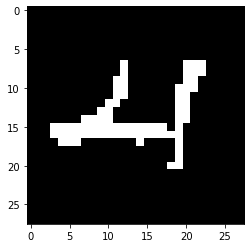

In [337]:
plt.imshow(ones_bin[5].T, cmap='gray')

In [338]:
zeros_flipped = [z.T for z in zeros_bin]
ones_flipped = [o.T for o in ones_bin]

In [279]:
flipped_zeros_amps = []
flipped_zeros_comp = []

for i, z in enumerate(zeros_flipped):
    
    im = make_binary(z, 122, 255)
    im[im == 1] = 255
    
    snake = active_contour(GaussianBlur(im, (3,3), 1), init, alpha=alpha, beta=beta, gamma=0.15, w_line=-0.1, coordinates='rc')    
    amps, comp = fetch_fourier_descriptors(snake, 2, scale=True, ignore_zero=True) 
    
    flipped_zeros_amps.append(amps)
    flipped_zeros_comp.append(comp)
    
flipped_ones_amps = []
flipped_ones_comp = []

for i, one in enumerate(ones_flipped):

    im = make_binary(one, 122, 255)
    im[im == 1] = 255
    
    snake = active_contour(GaussianBlur(im, (3,3), 1), init, alpha=alpha, beta=beta, gamma=0.15, w_line=-0.1, coordinates='rc')   
    amps, comp = fetch_fourier_descriptors(snake, 2, scale=True, ignore_zero=True)
    
    flipped_ones_amps.append(amps)
    ones_comp.append(comp)


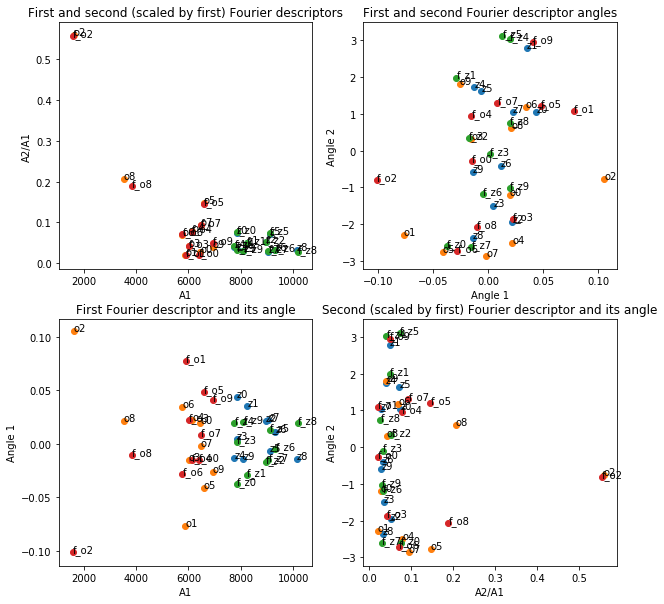

In [281]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

flipped_zeros_a1, flipped_zeros_a2 = np.array(flipped_zeros_amps)[:,0], np.array(flipped_zeros_amps)[:,1]
flipped_ones_a1, flipped_ones_a2 = np.array(flipped_ones_amps)[:,0], np.array(flipped_ones_amps)[:,1]

flipped_zeros_1_angle, flipped_zeros_2_angle = np.angle(flipped_zeros_comp)[:,0], np.angle(flipped_zeros_comp)[:,1]
flipped_ones_1_angle, flipped_ones_2_angle = np.angle(flipped_ones_comp)[:,0], np.angle(flipped_ones_comp)[:,1]

ax[0,0] = scatter_ax(ax[0,0], (zeros_a1, ones_a1), (zeros_a2, ones_a2), ('A1', 'A2/A1'), ('z','o'))
ax[0,0] = scatter_ax(ax[0,0], (flipped_zeros_a1, flipped_ones_a1), 
                     (flipped_zeros_a2, flipped_ones_a2),('A1', 'A2/A1'), ('f_z','f_o'))

ax[0,0].set_title('First and second (scaled by first) Fourier descriptors')

ax[0,1] = scatter_ax(ax[0,1], (zeros_1_angle, ones_1_angle), (zeros_2_angle, ones_2_angle), ('Angle 1', 'Angle 2'), ('z', 'o'))
ax[0,1] = scatter_ax(ax[0,1], (flipped_zeros_1_angle, flipped_ones_1_angle), 
                     (flipped_zeros_2_angle, flipped_ones_2_angle), ('Angle 1', 'Angle 2'), ('f_z', 'f_o'))

ax[0,1].set_title('First and second Fourier descriptor angles')

ax[1,0] = scatter_ax(ax[1,0], (zeros_a1, ones_a1), (zeros_1_angle, ones_1_angle), ('A1', 'Angle 1'), ('z','o'))
ax[1,0] = scatter_ax(ax[1,0], (flipped_zeros_a1, flipped_ones_a1), 
                     (flipped_zeros_1_angle, flipped_ones_1_angle), ('A1', 'Angle 1'), ('f_z','f_o'))

ax[1,0].set_title('First Fourier descriptor and its angle')

ax[1,1] = scatter_ax(ax[1,1], (zeros_a2, ones_a2), (zeros_2_angle, ones_2_angle), ('A2/A1', 'Angle 2'), ('z','o'))
ax[1,1] = scatter_ax(ax[1,1], (flipped_zeros_a2, flipped_ones_a2), 
                     (flipped_zeros_2_angle, flipped_ones_2_angle), ('A2/A1', 'Angle 2'), ('f_z','f_o'))

ax[1,1].set_title('Second (scaled by first) Fourier descriptor and its angle')

plt.show()

Cool! Notice the nice clustering in plot number one (only using amplitudes) and how using angles basically have made similar numbers (though flipped) complete opposites! (see how angle 1 is mirrored about zero in the lower leftmost plot)

### 1.3 Additional method(s)
Add your implementation and discussion

In [282]:
def is_pixel_set(im, pix):
    'Helper fn to freeman_path'
    
    return np.all(list(map(lambda x, y: x<y, pix, im.shape))) and im[pix]

In [283]:
from operator import add

def freeman_path(binary_im, x_init_offset=0, diagonals=True):

    x_max, y_max = binary_im.shape
    
    'Initialize search for boundary'
    x, y = x_max//2 + x_init_offset, 0

    'Find the first set pixel of the boundary'
    while not is_pixel_set(binary_im, (x,y)):
        y+=1
        assert y < y_max-1, f'No border found at x={x}'
    
    'Cardinal directions and their Freeman values'
    E, NE, N, NW, W, SW, S, SE = [i for i in range(8)]
    
    dirs = [E, NE, N, NW, W, SW, S, SE]

    'These are the dirs used when discovering new feasible paths'
    dirs_in_use = dirs    
    if not diagonals: dirs_in_use = [E, W, N, S]
    
    'Maps a cardinal direction to its pixel increment'
    dir_delta_map = {
        E: (1,0),
        NE: (1,1),
        N: (0,1),
        NW: (-1,1),
        W: (-1,0),
        SW: (-1,-1),
        S: (0,-1),
        SE: (1,-1)
    }
    
   
    'Init points. If we reach these again, the circle has been closed'
    x_init, y_init = x, y
    
    'Keep track of previously visited pixels to avoid loops'
    visited = []

    'If a path leads to a dead end, appropriate pixels are held responsible'
    failed_visits = set()
    
    
    'Initialize direction'
    current_dir = dirs_in_use[0]
    next_dir = current_dir
    
    encoded_path = []
    
    it = 0

    while it < 10000:
        
        it += 1
        
        'Set this if we find a feasible path away from current pixel'
        found_next_step = False

        'Been here, done that. Current pixel is added to path'
        visited.append((x,y))

        '...can we continue to move in our current direction?'
        coord_candidate = tuple(map(add, (x,y), dir_delta_map[current_dir]))
        
        if is_pixel_set(binary_im, coord_candidate) and coord_candidate not in failed_visits:
            encoded_path.append(next_dir)
            found_next_step = True
            
        else:
            for next_dir in dirs_in_use:
                if next_dir == current_dir: continue

                coord_candidate = tuple(map(add, (x,y), dir_delta_map[next_dir]))
                if coord_candidate in visited or coord_candidate in failed_visits: continue

                if is_pixel_set(binary_im, coord_candidate):
                    encoded_path.append(next_dir)
                    found_next_step = True
                    break
         
        if coord_candidate==(x_init, y_init):
            'Circle is closed. Head out'
            return x_init, y_init, np.array(encoded_path), np.array(visited)
           

        elif found_next_step:
            'Found new step, incrementing code and moving on'
            x, y = coord_candidate
            current_dir = next_dir 
            
        else:
            'We have reached a dead end!'

            try:
                'Try to go back one step and blacklist this pixel'
                failed_visits.add((x,y))
                
                x, y = visited[-2]
                visited = visited[:-2]
                
                current_dir = dirs[encoded_path[-2]]
                encoded_path = encoded_path[:-1]
                
            except:
                'Algorithm fails early (visited[-2] does not exist)'
                'Alter init slightly and run algorithm again'
                return freeman_path(binary_im, x_init_offset=x_init_offset+1, diagonals=diagonals)
            
    print('freeman_path FAILED')
    return x_init, y_init, encoded_path, visited

In [284]:
def restore_im_from_freeman_code(freeman_code, x_init, y_init, shape):
    
    E, NE, N, NW, W, SW, S, SE = [i for i in range(8)]

    directions = [E, NE, N, NW, W, SW, S, SE]
     
    'Maps a direction to their increments in x- and y values'
    dir_delta_map = {
        E: (1,0),
        NE: (1,1),
        N: (0,1),
        NW: (-1,1),
        W: (-1,0),
        SW: (-1,-1),
        S: (0,-1),
        SE: (1,-1)
    }
    
    im = np.zeros(shape)
    
    x, y = x_init, y_init
    
    coord = (x, y)
    
    im[coord] = 1
    
    for f in freeman_code:
        d = directions[f]
        coord = tuple(map(add, coord, dir_delta_map[d]))
        im[coord] = 1
        
    return im

In [655]:
def restore_im_from_coords(shape, coords):
    im = np.zeros(shape)
    for c in coords: im[c[0], c[1]] = 1
    return im

**Idea**:
 * Dilate the numbers and subtract the original.
 * You will be left with a border.
 * **But** zeros, for instance, have an inner border as well.
 * Borders might have thicknesses of more than one at points, and might have blind paths as well.
 * Find a point in the outermost border and initialize a freeman path encoder on it.
 * The encoder will try to move in a straight line until it reaches init point again.
 * If the encoder runs into a blind way, it will go one step back and try a different path.

In [287]:
from cv2 import dilate

In [288]:
im = zeros_im[9]
im_b = make_binary(im, 200, 255)

kernel = np.ones((3,3))
dil = dilate(im_b, kernel)

im_bord = dil-im_b

x,y,f,coords = freeman_path(im_bord, diagonals=False)
im_restored = restore_im_from_freeman_code(f, x, y, im_b.shape)

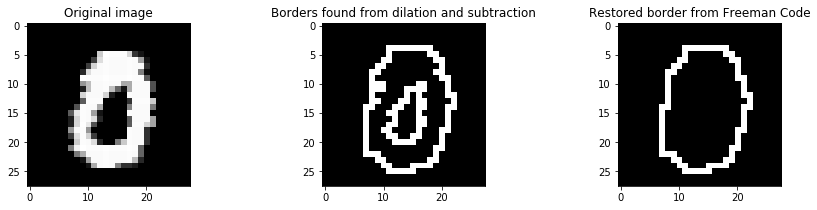

In [289]:
fig, ax = plt.subplots(1,3, figsize=(15,3))

ax[0].imshow(im, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(im_bord, cmap='gray')
ax[1].set_title('Borders found from dilation and subtraction')
ax[2].imshow(im_restored, cmap='gray')
ax[2].set_title('Restored border from Freeman Code')
plt.show()

In [292]:
kernel = np.ones((3,3))

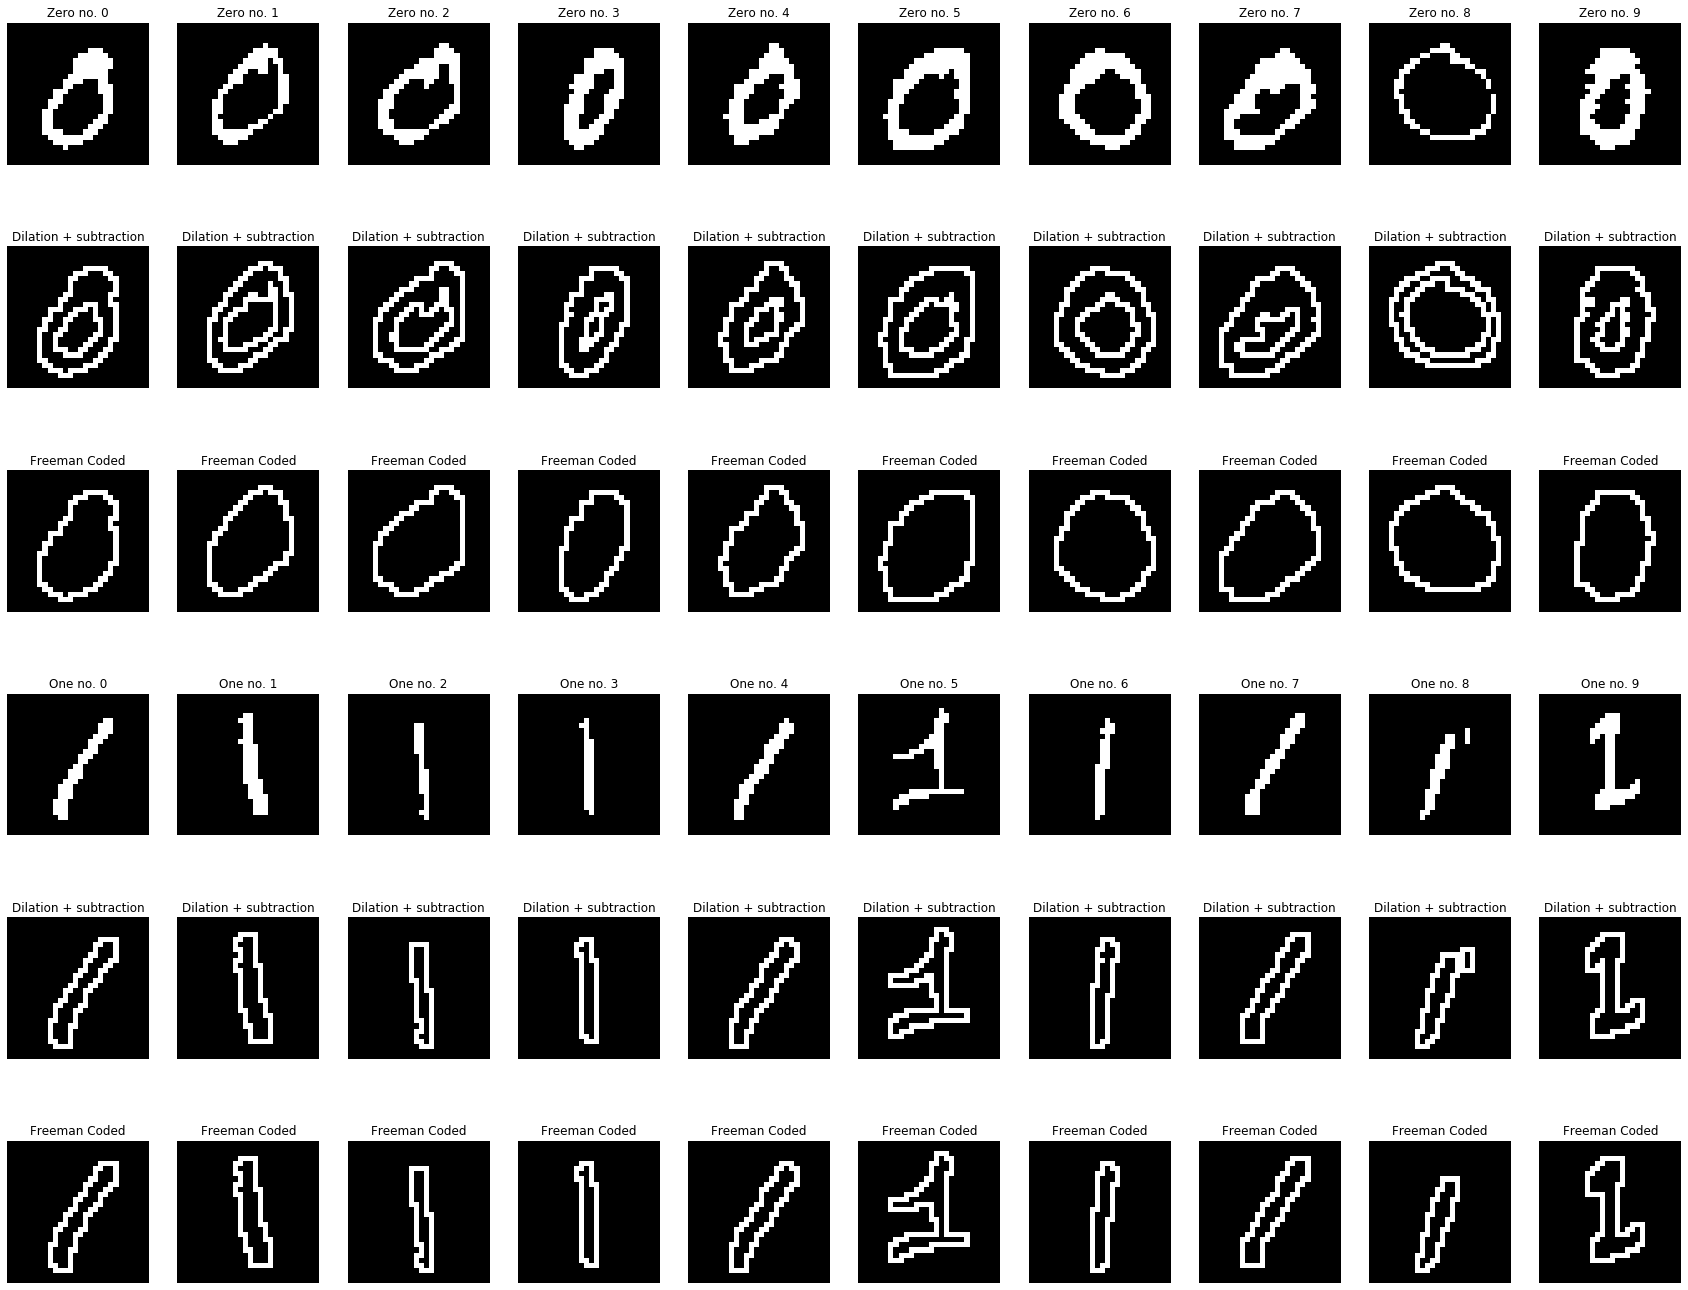

In [498]:
fig, ax = plt.subplots(6, 10, figsize=(10*3,4*6))

zeros_freeman_codes = []
zeros_coords = []
    
zeros_freeman_amps = []

for i, z in enumerate(zeros_bin):
    
    im = z.copy()
    
    dil = dilate(im, kernel)
    im_bord = dil-im

    x,y,f,coords = freeman_path(im_bord, diagonals=False)
    im_restored = restore_im_from_freeman_code(f, x, y, im.shape)
    
    zeros_freeman_codes.append(f)
    zeros_coords.append(coords)
    
    amps, _ = fetch_fourier_descriptors(coords, 2, scale=True, ignore_zero=True) 
    
    zeros_freeman_amps.append(amps)

    ax[0, i].imshow(im, cmap='gray')
    ax[0, i].set_title(f'Zero no. {i}')
    ax[0, i].axis('off')
    
    ax[1, i].imshow(im_bord, cmap='gray')
    ax[1, i].set_title(f'Dilation + subtraction')
    ax[1, i].axis('off')
    
    ax[2, i].imshow(im_restored, cmap='gray')
    ax[2, i].set_title(f'Freeman Coded')
    ax[2, i].axis('off')

    
ones_freeman_codes = []
ones_coords = []

ones_freeman_amps = []


for i, one in enumerate(ones_bin):

    im = one.copy()
    
    dil = dilate(im, kernel)
    im_bord = dil-im

    x,y,f,coords = freeman_path(im_bord, diagonals=False)
    im_restored = restore_im_from_freeman_code(f, x, y, im.shape)
    
    ones_freeman_codes.append(f)
    ones_coords.append(coords)
    
    amps, _ = fetch_fourier_descriptors(coords, 2, scale=True, ignore_zero=True) 
    
    ones_freeman_amps.append(amps)
    
    ax[3, i].imshow(im, cmap='gray')
    ax[3, i].axis('off')
    ax[3, i].set_title(f'One no. {i}')   
    
    ax[4, i].imshow(im_bord, cmap='gray')
    ax[4, i].axis('off')
    ax[4, i].set_title(f'Dilation + subtraction')  
    
    ax[5, i].imshow(im_restored, cmap='gray')
    ax[5, i].axis('off')
    ax[5, i].set_title(f'Freeman Coded')  


#### Fourier descriptors from Freeman path

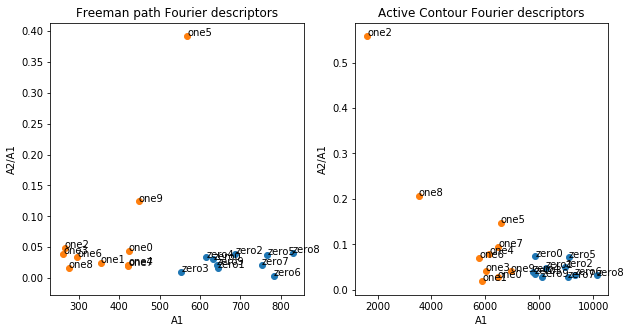

In [499]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

zeros_freeman_a1, zeros_freeman_a2 = np.array(zeros_freeman_amps)[:,0], np.array(zeros_freeman_amps)[:,1]
ones_freeman_a1, ones_freeman_a2 = np.array(ones_freeman_amps)[:,0], np.array(ones_freeman_amps)[:,1]

ax[0] = scatter_ax(ax[0], (zeros_freeman_a1, ones_freeman_a1), (zeros_freeman_a2, ones_freeman_a2), ('A1', 'A2/A1'), ('zero','one'))
ax[0].set_title('Freeman path Fourier descriptors')

ax[1] = scatter_ax(ax[1], (zeros_a1, ones_a1), (zeros_a2, ones_a2), ('A1', 'A2/A1'), ('zero','one'))
ax[1].set_title('Active Contour Fourier descriptors')

plt.show()

Old news, but interesting to see that it works. Also, manages to capture more the definite strangeness of one number five, where the active contour snake failed to land on the borders and (falsely) reports is to be a standard number one.

#### Edit distance

Now that we have the freeman path :)

In [478]:
from polyleven import levenshtein

def edit_dist_from_ref(ref, freeman_codes):
    n_classes = len(freeman_codes)
    ref_as_string = ''.join(ref.astype('str'))
    strings = [[''.join(f.astype('str')) for f in c] for c in freeman_codes]
    distances = [[levenshtein(d, ref_as_string) for d in arr] for arr in strings]
    return distances

#### Compacity

Since we move in straight lines, a nice perimeter approximation is the number of border pixels.

The summed binary (original) image is used as a measurement of the area.

In [479]:
def compacity(ims, freeman_codes, l_thr=150):
    perimeters = [[len(f) for f in c] for c in freeman_codes]
    areas = [[make_binary(i, l_thr, 255).sum() for i in im] for im in ims]
    compacities = [[p**2 / a for p, a in zip(per, ar)] for per, ar in zip(perimeters, areas)]
    return compacities

#### Edit distance and compacity

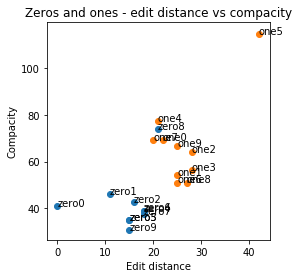

In [480]:
ref = zeros_freeman_codes[0]

zeros_d, ones_d = edit_dist_from_ref(ref, (zeros_freeman_codes, 
                                           ones_freeman_codes)) 

zeros_c, ones_c = compacity((zeros_im, ones_im), (zeros_freeman_codes, 
                                                  ones_freeman_codes))
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax = scatter_ax(ax, (zeros_d, ones_d), (zeros_c, ones_c),
                ('Edit distance', 'Compacity'), ('zero', 'one'))
ax.set_title('Zeros and ones - edit distance vs compacity')

plt.show()

Zero 8 looks strange. What if we allow it to become reference?

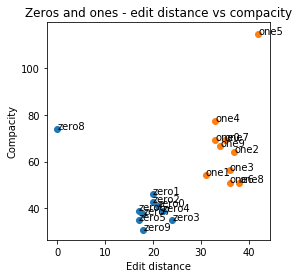

In [665]:
ref = zeros_freeman_codes[8]

zeros_d, ones_d = edit_dist_from_ref(ref, (zeros_freeman_codes, 
                                           ones_freeman_codes)) 

zeros_c, ones_c = compacity((zeros_im, ones_im), (zeros_freeman_codes, 
                                                  ones_freeman_codes))
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax = scatter_ax(ax, (zeros_d, ones_d), (zeros_c, ones_c),
                ('Edit distance', 'Compacity'), ('zero', 'one'))
ax.set_title('Zeros and ones - edit distance vs compacity')
plt.show()

Smile.

#### Axes of intertia

**Following cell** is fetched from [this](https://stackoverflow.com/questions/9005659/compute-eigenvectors-of-image-in-python) Stackoverflow thread.


In [482]:
def raw_moment(data, iord, jord):
    nrows, ncols = data.shape
    y, x = np.mgrid[:nrows, :ncols]
    data = data * x**iord * y**jord
    return data.sum()

def intertial_axis(data):
    'Calculate the x-mean, y-mean, and cov matrix of an image.'
    data_sum = data.sum()
    m10 = raw_moment(data, 1, 0)
    m01 = raw_moment(data, 0, 1)
    
    x_bar = m10 / data_sum
    y_bar = m01 / data_sum
    
    u11 = (raw_moment(data, 1, 1) - x_bar * m01) / data_sum
    u20 = (raw_moment(data, 2, 0) - x_bar * m10) / data_sum
    u02 = (raw_moment(data, 0, 2) - y_bar * m01) / data_sum
    cov = np.array([[u20, u11], [u11, u02]])

    return x_bar, y_bar, cov

def plot_bars(x_bar, y_bar, cov, ax):
    'Plot bars with a length of 2 stddev along the principal axes.'
    def make_lines(eigvals, eigvecs, mean, i):
        """Make lines a length of 2 stddev."""
        std = np.sqrt(eigvals[i])
        vec = 2 * std * eigvecs[:,i] / np.hypot(*eigvecs[:,i])
        x, y = np.vstack((mean-vec, mean, mean+vec)).T
        return x, y
    mean = np.array([x_bar, y_bar])
    eigvals, eigvecs = np.linalg.eigh(cov)
    print(eigvals)
    ax.plot(*make_lines(eigvals, eigvecs, mean, 0), marker='o', color='white')
    ax.plot(*make_lines(eigvals, eigvecs, mean, -1), marker='o', color='red')
    ax.axis('image')

##### Test

[ 4.35981376 38.0387727 ]


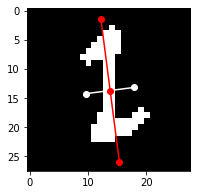

In [483]:
im = make_binary(ones_im[9], 150, 255)

x_bar, y_bar, cov = intertial_axis(im)

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow(im, cmap='gray')

plot_bars(x_bar, y_bar, cov, ax)
plt.show()

In [484]:
def ims_eigs(ims, l_thr=150):
    covs = [[intertial_axis(i)[2] for i in im] for im in ims]
    eigs = [np.array([np.linalg.eig(c)[0] for c in cov]) for cov in covs]
    return eigs

In [485]:
eigs = ims_eigs((zeros_bin, ones_bin))

(zeros_eig1, zeros_eig2), (ones_eig1, ones_eig2) = [(e[:,0], e[:,1]) for e in eigs]

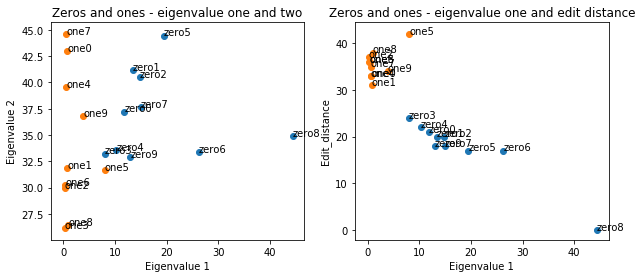

In [486]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0] = scatter_ax(ax[0], (zeros_eig1, ones_eig1), (zeros_eig2, ones_eig2),
                ('Eigenvalue 1', 'Eigenvalue 2'), ('zero', 'one'))
ax[0].set_title('Zeros and ones - eigenvalue one and two')

ax[1] = scatter_ax(ax[1], (zeros_eig1, ones_eig1), (zeros_d, ones_d),
                ('Eigenvalue 1', 'Edit_distance'), ('zero', 'one'))
ax[1].set_title('Zeros and ones - eigenvalue one and edit distance')

plt.show()

**Thoughts**
 * Eigenvalue 1 does have discriminative power.
 * Edit distance is really good though.

#### Chamfer distance

In [487]:
def create_chamfer_distance_map(im):
    x_max, y_max = im.shape
    
    d_map = np.ones(im.shape)*np.inf
    d_map[np.where(im)] = 0
    
    for _ in range(2):
        for xi in range(x_max):
            for yi in range(y_max):
                
                if not d_map[xi, yi]: continue

                predecessors = [d_map[xi, yi]]
                
                if xi-1 >= 0: 
                    predecessors.append(d_map[xi-1, yi] + 3)
                    if yi+1 < y_max: predecessors.append(d_map[xi-1, yi+1] + 4)
                
                if yi-1 >= 0: 
                    predecessors.append(d_map[xi, yi-1] + 3)
                    if xi-1 >= 0: predecessors.append(d_map[xi-1, yi-1] + 4)

                d_map[xi, yi] = min(predecessors)
                    
        d_map = np.rot90(np.rot90(d_map))
                    
    return d_map

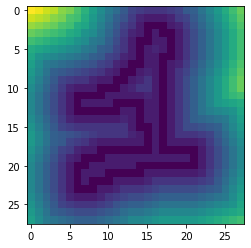

In [657]:
im = restore_im_from_coords(ones_im[5].shape, ones_coords[5])
ar = create_chamfer_distance_map(im)
plt.imshow(ar)
plt.show()

In [658]:
def calc_chamfer_distance(d_map, binary_im):
    d = d_map[np.where(binary_im)].sum()
    return d

**Note**:
Reference is probably important here, so we'll try one out and deduce something from the results

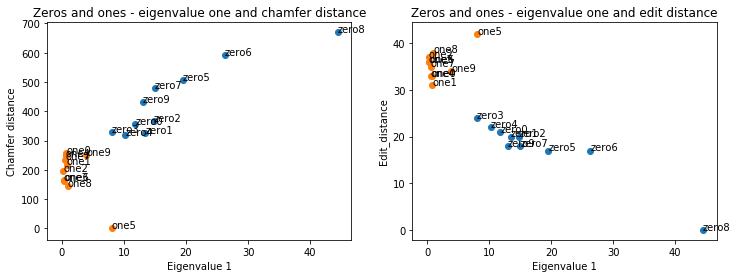

In [671]:
ref = restore_im_from_coords((28,28), ones_coords[5])

d_map = create_chamfer_distance_map(ref)

ones_chamfer_ds = [calc_chamfer_distance(d_map, restore_im_from_coords((28,28), c)) for c in ones_coords]
zeros_chamfer_ds = [calc_chamfer_distance(d_map, restore_im_from_coords((28,28), c)) for c in zeros_coords]


fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0] = scatter_ax(ax[0], (zeros_eig1, ones_eig1), (zeros_chamfer_ds, ones_chamfer_ds),
                ('Eigenvalue 1', 'Chamfer distance'), ('zero', 'one'))
ax[0].set_title('Zeros and ones - eigenvalue one and chamfer distance')

ax[1] = scatter_ax(ax[1], (zeros_eig1, ones_eig1), (zeros_d, ones_d),
                ('Eigenvalue 1', 'Edit_distance'), ('zero', 'one'))
ax[1].set_title('Zeros and ones - eigenvalue one and edit distance')

plt.show()

Cool! This is really good. Definite good separation (even though eigenvalue is not that good)

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

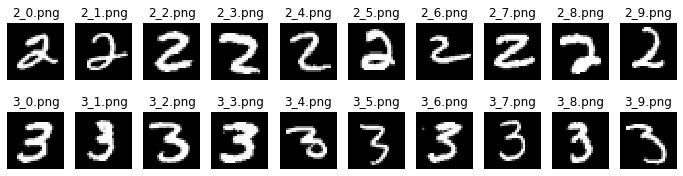

In [465]:
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

## Fourier descriptors

In [471]:
twos_bin = [make_binary(im, 150, 255) for im in twos_im]
threes_bin = [make_binary(im, 150, 255) for im in threes_im]

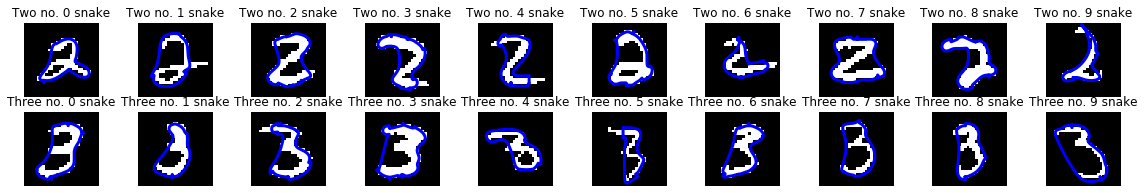

In [493]:
fig, ax = plt.subplots(2, len(zeros_im), figsize=(20,3))

twos_amps = []

for i, tw in enumerate(twos_bin):
    
    im = tw.copy()
    im[im == 1] = 255
    
    snake = active_contour(GaussianBlur(im, (3,3), 1), init, alpha=alpha, beta=beta, gamma=0.15, w_line=-0.1, coordinates='rc')    
    amps, _ = fetch_fourier_descriptors(snake, 2, scale=True, ignore_zero=True) 
    
    twos_amps.append(amps)
    
    ax[0, i].imshow(im, cmap=plt.cm.gray)
    ax[0, i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax[0, i].axis('off')
    ax[0, i].set_title(f'Two no. {i} snake')


threes_amps = []

for i, th in enumerate(threes_bin):

    im = th.copy()
    im[im == 1] = 255
    
    snake = active_contour(GaussianBlur(im, (3,3), 1), init, alpha=alpha, beta=beta, gamma=0.15, w_line=-0.1, coordinates='rc')   
    amps, _ = fetch_fourier_descriptors(snake, 2, scale=True, ignore_zero=True)
    
    threes_amps.append(amps)
    
    ax[1, i].imshow(im, cmap=plt.cm.gray)
    ax[1, i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax[1, i].axis('off')
    ax[1, i].set_title(f'Three no. {i} snake')

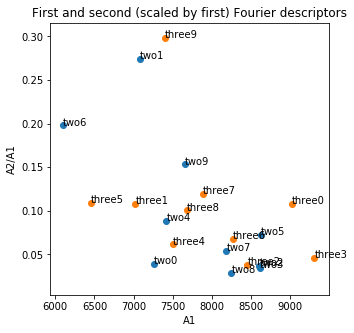

In [494]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

twos_a1, twos_a2 = np.array(twos_amps)[:,0], np.array(twos_amps)[:,1]
threes_a1, threes_a2 = np.array(threes_amps)[:,0], np.array(threes_amps)[:,1]

ax = scatter_ax(ax, (twos_a1, threes_a1), (twos_a2, threes_a2), ('A1', 'A2/A1'), ('two','three'))
ax.set_title('First and second (scaled by first) Fourier descriptors')

plt.show()

**First and foremost**: This is a mess. We have not succeeded in tuning the snakes better, and have instead relied on our other methods.

#### Find fourier descriptors from freeman code

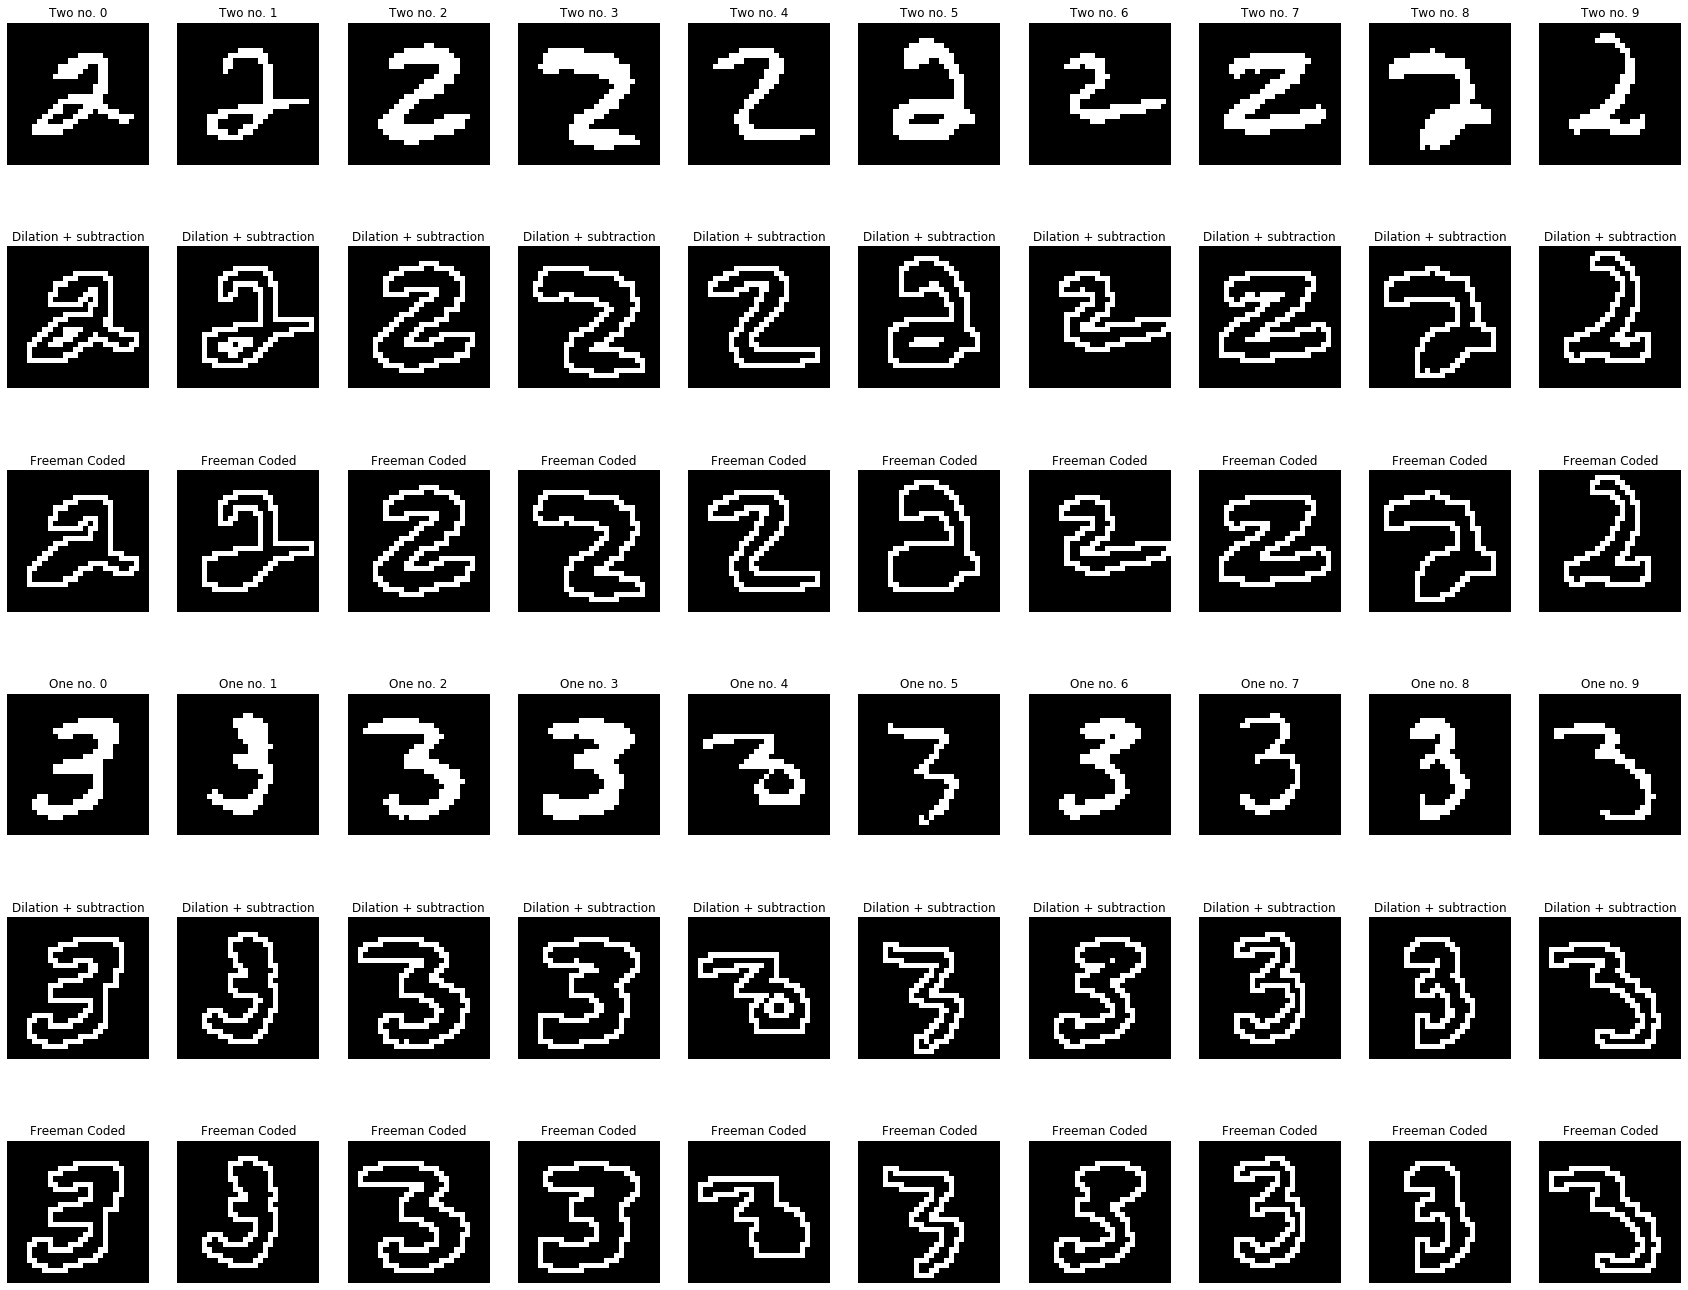

In [500]:
fig, ax = plt.subplots(6, 10, figsize=(10*3,4*6))

twos_freeman_codes = []
twos_coords = []
    
twos_freeman_amps = []

for i, tw in enumerate(twos_bin):
    
    im = tw.copy()
    
    dil = dilate(im, kernel)
    im_bord = dil-im

    x,y,f,coords = freeman_path(im_bord, diagonals=False)
    im_restored = restore_im_from_freeman_code(f, x, y, im.shape)
    
    twos_freeman_codes.append(f)
    twos_coords.append(coords)
    
    amps, _ = fetch_fourier_descriptors(coords, 2, scale=True, ignore_zero=True) 
    
    twos_freeman_amps.append(amps)

    ax[0, i].imshow(im, cmap='gray')
    ax[0, i].set_title(f'Two no. {i}')
    ax[0, i].axis('off')
    
    ax[1, i].imshow(im_bord, cmap='gray')
    ax[1, i].set_title(f'Dilation + subtraction')
    ax[1, i].axis('off')
    
    ax[2, i].imshow(im_restored, cmap='gray')
    ax[2, i].set_title(f'Freeman Coded')
    ax[2, i].axis('off')

    
threes_freeman_codes = []
threes_coords = []

threes_freeman_amps = []


for i, th in enumerate(threes_bin):

    im = th.copy()
    
    dil = dilate(im, kernel)
    im_bord = dil-im

    x,y,f,coords = freeman_path(im_bord, diagonals=False)
    im_restored = restore_im_from_freeman_code(f, x, y, im.shape)
    
    threes_freeman_codes.append(f)
    threes_coords.append(coords)
    
    amps, _ = fetch_fourier_descriptors(coords, 2, scale=True, ignore_zero=True) 
    
    threes_freeman_amps.append(amps)
    
    ax[3, i].imshow(im, cmap='gray')
    ax[3, i].axis('off')
    ax[3, i].set_title(f'One no. {i}')   
    
    ax[4, i].imshow(im_bord, cmap='gray')
    ax[4, i].axis('off')
    ax[4, i].set_title(f'Dilation + subtraction')  
    
    ax[5, i].imshow(im_restored, cmap='gray')
    ax[5, i].axis('off')
    ax[5, i].set_title(f'Freeman Coded')  

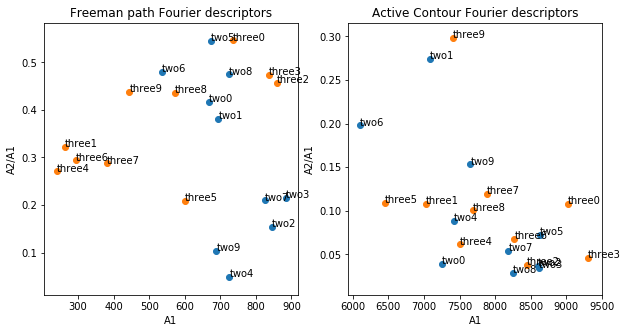

In [501]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

twos_freeman_a1, twos_freeman_a2 = np.array(twos_freeman_amps)[:,0], np.array(twos_freeman_amps)[:,1]
threes_freeman_a1, threes_freeman_a2 = np.array(threes_freeman_amps)[:,0], np.array(threes_freeman_amps)[:,1]

ax[0] = scatter_ax(ax[0], (twos_freeman_a1, threes_freeman_a1), (twos_freeman_a2, threes_freeman_a2), ('A1', 'A2/A1'), ('two','three'))
ax[0].set_title('Freeman path Fourier descriptors')

ax[1] = scatter_ax(ax[1], (twos_a1, threes_a1), (twos_a2, threes_a2), ('A1', 'A2/A1'), ('two','three'))
ax[1].set_title('Active Contour Fourier descriptors')

plt.show()

That's arguably better than with the bad active contour snakes, but still not a very good separation.

## Implement our previously discovered techniques on all numbers

### A1 and others
Fourier descriptor A1 (From e.g. freeman codes) is a powerful way to distinguish ones and zeros, but struggles with the other categories.

In [673]:
ref = twos_freeman_codes[7]

zeros_d, ones_d, twos_d, threes_d = edit_dist_from_ref(ref, (zeros_freeman_codes, 
                                           ones_freeman_codes, twos_freeman_codes, threes_freeman_codes)) 

ref = threes_bin[8]

d_map = create_chamfer_distance_map(ref)

zeros_chamfer_ds = [calc_chamfer_distance(d_map, im) for im in zeros_bin]
ones_chamfer_ds = [calc_chamfer_distance(d_map, im) for im in ones_bin]
twos_chamfer_ds = [calc_chamfer_distance(d_map, im) for im in twos_bin]
threes_chamfer_ds = [calc_chamfer_distance(d_map, im) for im in threes_bin]

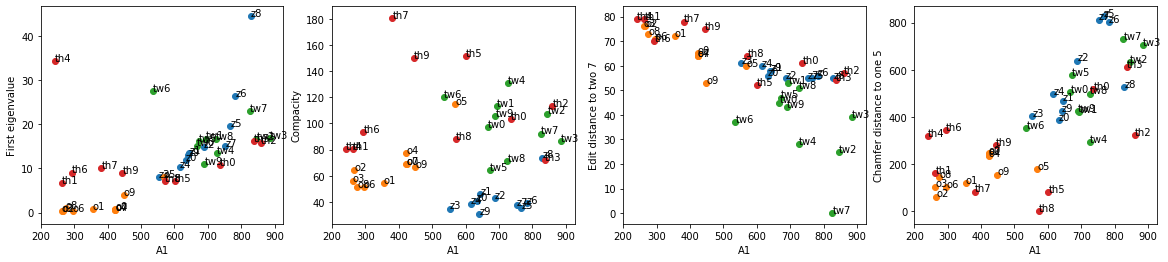

In [675]:
fig, ax = plt.subplots(1,4, figsize=(20,4))

ax[0] = scatter_ax(ax[0], (zeros_freeman_a1, ones_freeman_a1, twos_freeman_a1, threes_freeman_a1), 
                (zeros_eig1, ones_eig1, twos_eig1, threes_eig1),
                ('A1', 'First eigenvalue'), 
                ('z', 'o', 'tw', 'th'))

ax[1] = scatter_ax(ax[1], (zeros_freeman_a1, ones_freeman_a1, twos_freeman_a1, threes_freeman_a1),
                (zeros_c, ones_c, twos_c, threes_c),
                ('A1', 'Compacity'), 
                ('z', 'o', 'tw', 'th'))

ax[2] = scatter_ax(ax[2], (zeros_freeman_a1, ones_freeman_a1, twos_freeman_a1, threes_freeman_a1), 
                (zeros_d, ones_d, twos_d, threes_d),
                ('A1', 'Edit distance to two 7'), 
                ('z', 'o', 'tw', 'th'))

ax[3] = scatter_ax(ax[3], (zeros_freeman_a1, ones_freeman_a1, twos_freeman_a1, threes_freeman_a1),
                (zeros_chamfer_ds, ones_chamfer_ds, twos_chamfer_ds, threes_chamfer_ds),
                ('A1', 'Chamfer distance to one 5'), 
                ('z', 'o', 'tw', 'th'))

plt.show()

**Thoughts here**: 
 * A1 separates zeros from ones, and ones from twos.
 * Need second feature to separate threes from the rest, and twos from zeros.
 * Can probably sit and tune all day. Can't separate threes very much better here.

**A1 is probably not favorable since it has so little power in discriminating twos and threes**

#### Edit distances and compacity

In [676]:
twos_c, threes_c = compacity((twos_im, threes_im), (twos_freeman_codes, 
                                                  threes_freeman_codes))

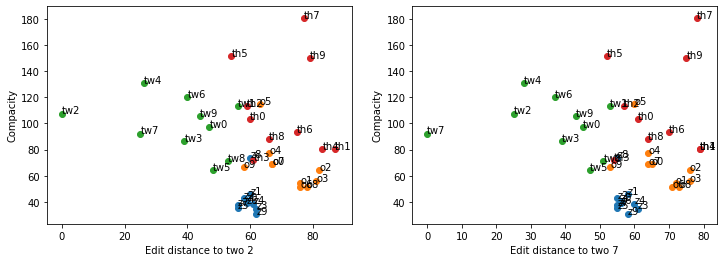

In [677]:
ref = twos_freeman_codes[2]

zeros_d22, ones_d22, twos_d22, threes_d22 = edit_dist_from_ref(ref, 
                                                       (zeros_freeman_codes, 
                                                       ones_freeman_codes, 
                                                       twos_freeman_codes, 
                                                       threes_freeman_codes))

ref = twos_freeman_codes[7]
zeros_d27, ones_d27, twos_d27, threes_d27 = edit_dist_from_ref(ref, 
                                                       (zeros_freeman_codes, 
                                                       ones_freeman_codes, 
                                                       twos_freeman_codes, 
                                                       threes_freeman_codes))

fig, ax = plt.subplots(1,2,figsize=(12,4))


ax[0] = scatter_ax(ax[0], (zeros_d22, ones_d22, twos_d22, threes_d22),
                (zeros_c, ones_c, twos_c, threes_c),
                ('Edit distance to two 2', 'Compacity'), ('z', 'o', 'tw', 'th'))
ax[1] = scatter_ax(ax[1], (zeros_d27, ones_d27, twos_d27, threes_d27),
                (zeros_c, ones_c, twos_c, threes_c),
                ('Edit distance to two 7', 'Compacity'), ('z', 'o', 'tw', 'th'))

plt.show()

The idea here is to pick typical representations of one class as a reference in order to pull the other members of that class towards 0 edit distance. If we, for instance, picked the atypical one number 5, it wouldn't do much separation. The other twos have been tried as well, but performed -as expected- worse, since they are more atypical for their class.

## First eigenvalue and others

In [678]:
eigs = ims_eigs((twos_bin, threes_bin))

(twos_eig1, twos_eig2), (threes_eig1, threes_eig2) = [(e[:,0], e[:,1]) for e in eigs]

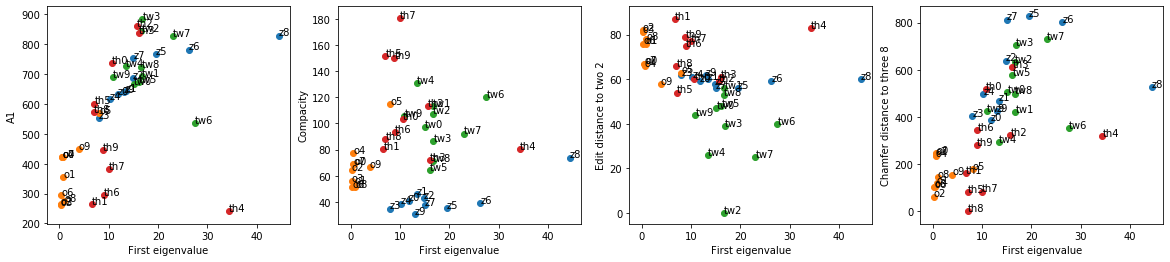

In [679]:
fig, ax = plt.subplots(1,4, figsize=(20,4))

ax[0] = scatter_ax(ax[0], (zeros_eig1, ones_eig1, twos_eig1, threes_eig1), 
                (zeros_freeman_a1, ones_freeman_a1, twos_freeman_a1, threes_freeman_a1),
                ('First eigenvalue', 'A1'), 
                ('z', 'o', 'tw', 'th'))

ax[1] = scatter_ax(ax[1], (zeros_eig1, ones_eig1, twos_eig1, threes_eig1), 
                (zeros_c, ones_c, twos_c, threes_c),
                ('First eigenvalue', 'Compacity'), 
                ('z', 'o', 'tw', 'th'))

ax[2] = scatter_ax(ax[2], (zeros_eig1, ones_eig1, twos_eig1, threes_eig1), 
                (zeros_d22, ones_d22, twos_d22, threes_d22),
                ('First eigenvalue', 'Edit distance to two 2'), 
                ('z', 'o', 'tw', 'th'))

ax[3] = scatter_ax(ax[3], (zeros_eig1, ones_eig1, twos_eig1, threes_eig1), 
                (zeros_chamfer_ds, ones_chamfer_ds, twos_chamfer_ds, threes_chamfer_ds),
                ('First eigenvalue', 'Chamfer distance to three 8'), 
                ('z', 'o', 'tw', 'th'))

plt.show()

## A2 and others

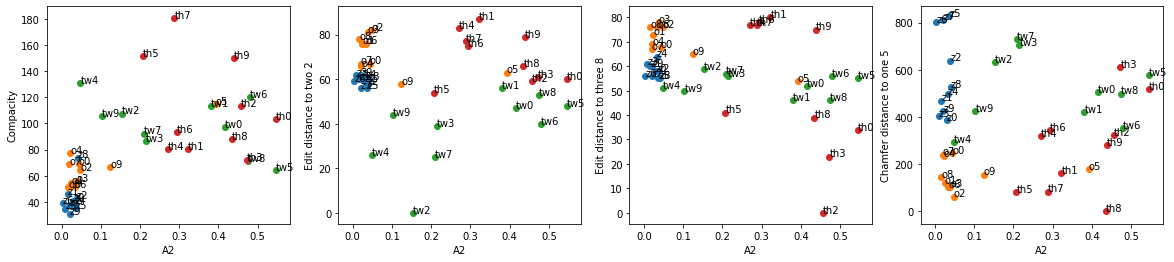

In [681]:
fig, ax = plt.subplots(1,4, figsize=(20,4))

ax[0] = scatter_ax(ax[0], (zeros_freeman_a2, ones_freeman_a2, twos_freeman_a2, threes_freeman_a2),
                (zeros_c, ones_c, twos_c, threes_c),
                ('A2', 'Compacity'), 
                ('z', 'o', 'tw', 'th'))

ax[1] = scatter_ax(ax[1], (zeros_freeman_a2, ones_freeman_a2, twos_freeman_a2, threes_freeman_a2),
                (zeros_d22, ones_d22, twos_d22, threes_d22),
                ('A2', 'Edit distance to two 2'), 
                ('z', 'o', 'tw', 'th'))

ax[2] = scatter_ax(ax[2], (zeros_freeman_a2, ones_freeman_a2, twos_freeman_a2, threes_freeman_a2),
                (zeros_d32, ones_d32, twos_d32, threes_d32),
                ('A2', 'Edit distance to three 8'), 
                ('z', 'o', 'tw', 'th'))

ax[3] = scatter_ax(ax[3], (zeros_freeman_a2, ones_freeman_a2, twos_freeman_a2, threes_freeman_a2),
                (zeros_chamfer_ds, ones_chamfer_ds, twos_chamfer_ds, threes_chamfer_ds),
                ('A2', 'Chamfer distance to one 5'), 
                ('z', 'o', 'tw', 'th'))
plt.show()